### Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

from sklearn.linear_model import LogisticRegression 

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

### Импортируем модель и данные

In [2]:
#Данные о покупках в магазине
df_purchase = pd.read_csv('purchase data.csv')
#контейнер со скейлером
scaler = pickle.load(open('scaler.pickle', 'rb'))
#контейнер с Principal Component Analysis
pca = pickle.load(open('pca.pickle', 'rb'))
#модель сегментирования
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))
#признаки
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
#создаём датафрейм со стандартизированными признаками
df_purchase_segm_std = scaler.transform(features)
#вычленяем принципиальные компоненты (должно быть 4)
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
#создаёем датафрейм с сегментированными пользователями
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

#копируем изначальный датафрейм в новый
df_purchase_predictors = df_purchase.copy()
#создаём дамми категории на основе значений столбца Segment
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep= '_')
#соединяем свежесозданный датафрейм с дамми-категориями сегментами
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis=1)

In [3]:
df_pa = df_purchase_predictors

## Модель вероятности покупки

In [4]:
#Целевой признак - столбец Incidence
Y = df_pa['Incidence']

In [5]:
#Модель будет основываться на средней цене
X = pd.DataFrame()
X['Mean Price'] = np.sum(df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']], axis=1)/5

In [6]:
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [7]:
model_purchase.coef_

array([[-2.34808487]])

## Влияние стоимости на вероятность покупки (ценовая эластичность)

Рассчитаем на сколько % меняется вероятность покупки при изменении стоимости товаров на один пункт

In [8]:
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


создаём ценовой диапазон меньше min и больше max значения, с шагом 0.01

In [9]:
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [10]:
#преобразуем в датафрейм
df_price_range = pd.DataFrame(price_range)

In [11]:
#используем модель регрессии, для предсказания вероятности покупки при каждом значении цены
Y_pr = model_purchase.predict_proba(df_price_range)

In [12]:
#Выдаются вероятности неудачного и удачного исходов, нам нужен последний столбец
purchase_pr = Y_pr[:][:, 1]

In [13]:
#рассчитываем эластичность: beta - коэффициент из модели логистической регрессии * ценовой диапазон * (1 - вероятность покупки)
pe = model_purchase.coef_[:, 0] * price_range * (1-purchase_pr)

In [14]:
#Создаём датафрейм, куда будем помещать расчёты эластичности, за основу берём ценовой диапазон
df_price_elasticities = pd.DataFrame(price_range)

In [15]:
#ранее была получена эластичность на основе средней цены, добавляем столбец Mean_PE
df_price_elasticities = df_price_elasticities.rename(columns = {0: 'Price_Point'})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities.head(10)

,Price_Point,Mean_PE
0,0.50,-0.096272
1,0.51,-0.100335
2,0.52,-0.104525
3,0.53,-0.108845
4,0.54,-0.113298
5,0.55,-0.117887
6,0.56,-0.122617
7,0.57,-0.127489
8,0.58,-0.132508
9,0.59,-0.137677


Построим график эластичности

Text(0.5, 1.0, 'Ценовая эластичность вероятности покупки')

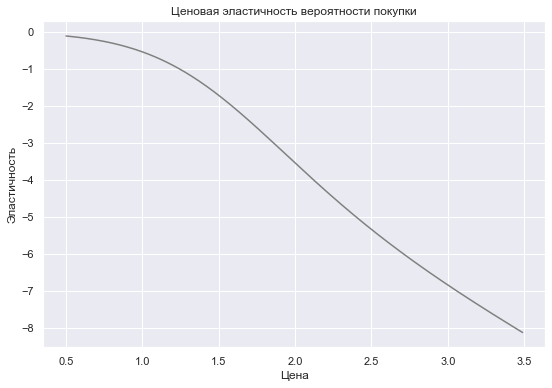

In [16]:
plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Цена')
plt.ylabel('Эластичность')
plt.title('Ценовая эластичность вероятности покупки')

При значении эластичности от -1 до 0 спрос считается неэластичным, то есть меняется меньше, чем цена, от -1 и ниже - эластичным


## Расчёт эластичности вероятности покупки по сегментам

Проведём рассчёт эластичности для каждого сегмента в отдельности, затем построим кривые для сравнения

### Сегмент 0 - Well-off

In [17]:
df_pa_segment_0 = df_pa[df_pa['Segment_0']==1]

In [18]:
df_pa_segment_0.head(10)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,1,52,2,159052,2,1,1,0,0,0
102,200000002,11,0,0,0,4,1,1.51,1.89,1.99,...,1,52,2,159052,2,1,1,0,0,0
103,200000002,18,0,0,0,0,0,1.52,1.89,1.99,...,1,52,2,159052,2,1,1,0,0,0
104,200000002,24,0,0,0,0,0,1.50,1.90,1.99,...,1,52,2,159052,2,1,1,0,0,0
105,200000002,25,0,0,0,0,0,1.50,1.90,1.99,...,1,52,2,159052,2,1,1,0,0,0
106,200000002,38,0,0,0,0,0,1.50,1.90,1.99,...,1,52,2,159052,2,1,1,0,0,0
107,200000002,43,0,0,0,0,0,1.35,1.58,1.97,...,1,52,2,159052,2,1,1,0,0,0
108,200000002,50,0,0,0,0,0,1.35,1.87,1.93,...,1,52,2,159052,2,1,1,0,0,0
109,200000002,58,0,0,0,0,0,1.39,1.90,1.91,...,1,52,2,159052,2,1,1,0,0,0
110,200000002,63,0,0,0,0,0,1.39,1.89,1.91,...,1,52,2,159052,2,1,1,0,0,0


In [19]:
Y = df_pa_segment_0['Incidence']

In [20]:
X = pd.DataFrame()

In [21]:
X['Mean_Price'] = np.sum(df_pa_segment_0[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']], axis=1)/5

In [22]:
model_incidence_segment_0 = LogisticRegression(solver = 'sag')
model_incidence_segment_0.fit(X,Y)

LogisticRegression(solver='sag')

In [23]:
model_incidence_segment_0.coef_

array([[-1.24604879]])

In [24]:
Y_segment_0 = model_incidence_segment_0.predict_proba(df_price_range)
purchase_pr_segment_0 = Y_segment_0[:][:, 1]
pe_segment_0 = model_incidence_segment_0.coef_[:, 0] * price_range * (1-purchase_pr_segment_0)

In [25]:
df_price_elasticities['PE_Segment_0'] = pe_segment_0
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0
0,0.50,-0.096272,-0.168122
1,0.51,-0.100335,-0.173049
2,0.52,-0.104525,-0.178047
3,0.53,-0.108845,-0.183115
4,0.54,-0.113298,-0.188255
...,...,...,...
295,3.45,-8.012885,-4.023153
296,3.46,-8.038137,-4.038021
297,3.47,-8.063355,-4.052873
298,3.48,-8.088539,-4.067709


### Сегмент 1 - Career Focused / "Карьеристы"

In [26]:
df_pa_segment_1 = df_pa[df_pa['Segment_1']==1]

In [27]:
df_pa_segment_1

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
370,200000005,7,0,0,0,0,0,1.59,1.88,2.01,...,0,49,1,121466,1,2,0,1,0,0
371,200000005,13,0,0,0,0,0,1.51,1.89,1.99,...,0,49,1,121466,1,2,0,1,0,0
372,200000005,20,0,0,0,0,0,1.52,1.89,1.99,...,0,49,1,121466,1,2,0,1,0,0
373,200000005,32,0,0,0,0,0,1.50,1.90,1.99,...,0,49,1,121466,1,2,0,1,0,0
374,200000005,39,0,0,0,0,0,1.50,1.90,1.99,...,0,49,1,121466,1,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57587,200000491,697,1,5,5,5,1,1.42,1.51,1.97,...,0,35,1,150237,2,2,0,1,0,0
57588,200000491,704,1,5,5,5,1,1.41,1.85,2.01,...,0,35,1,150237,2,2,0,1,0,0
57589,200000491,714,1,5,1,5,1,1.50,1.80,2.09,...,0,35,1,150237,2,2,0,1,0,0
57590,200000491,718,1,5,5,5,1,1.50,1.80,2.14,...,0,35,1,150237,2,2,0,1,0,0


In [28]:
Y = df_pa_segment_1['Incidence']

In [29]:
X = pd.DataFrame()

In [30]:
X['Mean_Price'] = np.sum(df_pa_segment_1[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']], axis=1)/5

In [31]:
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X,Y)

LogisticRegression(solver='sag')

In [32]:
model_incidence_segment_1.coef_

array([[-1.65206299]])

In [33]:
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1-purchase_pr_segment_1)

In [34]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1
0,0.50,-0.096272,-0.168122,-0.117613
1,0.51,-0.100335,-0.173049,-0.121675
2,0.52,-0.104525,-0.178047,-0.125825
3,0.53,-0.108845,-0.183115,-0.130063
4,0.54,-0.113298,-0.188255,-0.134392
...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686
296,3.46,-8.038137,-4.038021,-5.468424
297,3.47,-8.063355,-4.052873,-5.488126
298,3.48,-8.088539,-4.067709,-5.507791


### Сегмент 2 - Fewer-Opportunities

In [35]:
df_pa_segment_2 = df_pa[df_pa['Segment_2']==1]

In [36]:
df_pa_segment_2

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,47,1,110866,1,0,0,0,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,47,1,110866,1,0,0,0,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,47,1,110866,1,0,0,0,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,47,1,110866,1,0,0,0,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,47,1,110866,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58688,200000500,703,0,0,0,2,1,1.41,1.85,2.01,...,0,42,1,120946,1,0,0,0,1,0
58689,200000500,710,0,0,0,0,0,1.36,1.84,2.09,...,0,42,1,120946,1,0,0,0,1,0
58690,200000500,717,0,0,0,0,0,1.50,1.80,2.14,...,0,42,1,120946,1,0,0,0,1,0
58691,200000500,722,1,2,3,0,0,1.51,1.82,2.09,...,0,42,1,120946,1,0,0,0,1,0


In [37]:
Y = df_pa_segment_2['Incidence']

In [38]:
X = pd.DataFrame()

In [39]:
X['Mean_Price'] = np.sum(df_pa_segment_2[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']], axis=1)/5

In [40]:
model_incidence_segment_2 = LogisticRegression(solver = 'sag')
model_incidence_segment_2.fit(X,Y)

LogisticRegression(solver='sag')

In [41]:
model_incidence_segment_2.coef_

array([[-3.58565898]])

In [42]:
Y_segment_2 = model_incidence_segment_2.predict_proba(df_price_range)
purchase_pr_segment_2 = Y_segment_2[:][:, 1]
pe_segment_2 = model_incidence_segment_2.coef_[:, 0] * price_range * (1-purchase_pr_segment_2)

In [43]:
df_price_elasticities['PE_Segment_2'] = pe_segment_2
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745
...,...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686,-12.353623
296,3.46,-8.038137,-4.038021,-5.468424,-12.390027
297,3.47,-8.063355,-4.052873,-5.488126,-12.426413
298,3.48,-8.088539,-4.067709,-5.507791,-12.462782


### Сегмент 3 - Standard

In [44]:
df_pa_segment_3 = df_pa[df_pa['Segment_3']==1]

In [45]:
df_pa_segment_3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
2395,200000024,10,0,0,0,0,0,1.51,1.89,1.99,...,1,32,1,88428,0,0,0,0,0,1
2396,200000024,18,0,0,0,0,0,1.52,1.89,1.99,...,1,32,1,88428,0,0,0,0,0,1
2397,200000024,33,0,0,0,0,0,1.50,1.90,1.99,...,1,32,1,88428,0,0,0,0,0,1
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,1,32,1,88428,0,0,0,0,0,1
2399,200000024,51,0,0,0,2,1,1.35,1.87,1.93,...,1,32,1,88428,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58458,200000498,705,0,0,0,0,0,1.49,1.87,1.99,...,1,29,1,114784,1,0,0,0,0,1
58459,200000498,712,0,0,0,0,0,1.50,1.84,2.13,...,1,29,1,114784,1,0,0,0,0,1
58460,200000498,719,0,0,0,0,0,1.50,1.80,2.14,...,1,29,1,114784,1,0,0,0,0,1
58461,200000498,725,1,2,5,0,0,1.51,1.82,2.09,...,1,29,1,114784,1,0,0,0,0,1


In [46]:
Y = df_pa_segment_3['Incidence']

In [47]:
X = pd.DataFrame()

In [48]:
X['Mean_Price'] = np.sum(df_pa_segment_3[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']], axis=1)/5

In [49]:
model_incidence_segment_3 = LogisticRegression(solver = 'sag')
model_incidence_segment_3.fit(X,Y)

LogisticRegression(solver='sag')

In [50]:
model_incidence_segment_3.coef_

array([[-1.50889669]])

In [51]:
Y_segment_3 = model_incidence_segment_3.predict_proba(df_price_range)
purchase_pr_segment_3 = Y_segment_3[:][:, 1]
pe_segment_3 = model_incidence_segment_3.coef_[:, 0] * price_range * (1-purchase_pr_segment_3)

In [52]:
df_price_elasticities['PE_Segment_3'] = pe_segment_3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986
...,...,...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686,-12.353623,-5.062334
296,3.46,-8.038137,-4.038021,-5.468424,-12.390027,-5.079102
297,3.47,-8.063355,-4.052873,-5.488126,-12.426413,-5.095852
298,3.48,-8.088539,-4.067709,-5.507791,-12.462782,-5.112585


### Кривые эластичности по сегментам

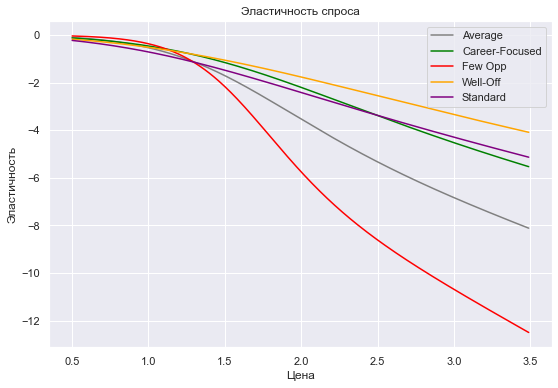

In [53]:
plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment_2, color = 'red')
plt.plot(price_range, pe_segment_0, color = 'Orange')
plt.plot(price_range, pe_segment_3, color = 'Purple')
plt.xlabel('Цена')
plt.ylabel('Эластичность')
plt.title('Эластичность спроса')
plt.legend(['Average', 'Career-Focused', 'Few Opp', 'Well-Off', 'Standard'])

-Семент fewer opportunities в начале наименее эластичен из всех сегментов, но резко становится эластичным после цены 1.25 и затем наиболее склонен к отказу от покупки с повышением цены
(также по нему имеем больше всего данных, что может приводить к повышенной точности модели)
-Сегмент Standard становится эластичным чуть раньше, при цене 1.22
-Сегмент Well-Off наименее эластичен


## Вероятность покупки по промо акции

### Подготовка данных

In [54]:
Y=df_pa['Incidence']

In [55]:
X=pd.DataFrame()
X['Mean_Price']=np.sum(df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']], axis=1)/5

In [56]:
X['Mean_Promotion'] = np.sum(df_pa[['Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4', 'Promotion_5']], axis=1)/5
X

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0
...,...,...
58688,2.060,0.2
58689,2.060,0.0
58690,2.086,0.0
58691,2.092,0.0


### Моделирование

In [57]:
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49406513,  0.56151868]])

### Эластичность с учётом промо акций


In [58]:
df_price_elasticitiy_promotion = pd.DataFrame(price_range)
df_price_elasticitiy_promotion = df_price_elasticitiy_promotion.rename(columns = {0: 'Price_Range'})

In [59]:
df_price_elasticitiy_promotion['Promotion'] = 1

In [60]:
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticitiy_promotion)

In [61]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0]*price_range)*(1-promo)

In [62]:
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682
...,...,...,...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686,-12.353623,-5.062334,-4.861790
296,3.46,-8.038137,-4.038021,-5.468424,-12.390027,-5.079102,-4.879992
297,3.47,-8.063355,-4.052873,-5.488126,-12.426413,-5.095852,-4.898164
298,3.48,-8.088539,-4.067709,-5.507791,-12.462782,-5.112585,-4.916305


### Эластичность без промо акций

In [63]:
df_price_elasticitiy_no_promotion = pd.DataFrame(price_range)
df_price_elasticitiy_no_promotion = df_price_elasticitiy_no_promotion.rename(columns = {0: 'Price_Range'})

In [64]:
df_price_elasticitiy_no_promotion['Promotion'] = 0

In [65]:
Y_no_promotion = model_incidence_promotion.predict_proba(df_price_elasticitiy_no_promotion)

In [66]:
no_promo = Y_no_promotion[:, 1]
price_elasticity_no_promo = (model_incidence_promotion.coef_[:, 0]*price_range)*(1-no_promo)

In [67]:
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo
df_price_elasticities.head(40)

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758
5,0.55,-0.117887,-0.193466,-0.138813,-0.042981,-0.255238,-0.147120,-0.227295
6,0.56,-0.122617,-0.198750,-0.143326,-0.045324,-0.262602,-0.151641,-0.233937
7,0.57,-0.127489,-0.204107,-0.147934,-0.047779,-0.270079,-0.156246,-0.240686
8,0.58,-0.132508,-0.209537,-0.152638,-0.050349,-0.277669,-0.160936,-0.247542
9,0.59,-0.137677,-0.215041,-0.157438,-0.053040,-0.285374,-0.165712,-0.254506


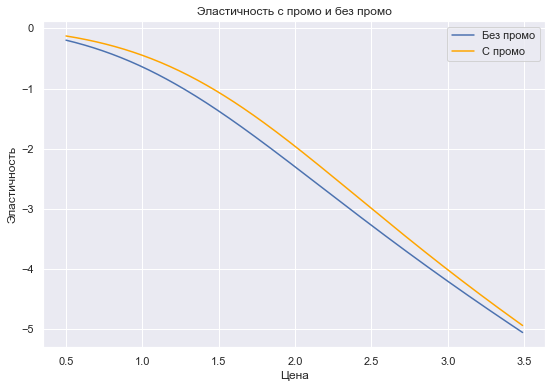

In [68]:
plt.figure(figsize=(9,6))
plt.plot(price_range, price_elasticity_no_promo)
plt.plot(price_range, price_elasticity_promo, color = 'Orange')
plt.xlabel('Цена')
plt.ylabel('Эластичность')
plt.title('Эластичность с промо и без промо')
plt.legend(['Без промо', 'С промо'])

С промоакциями имеем при большей цене меньшую эластичность, то есть при равных ценах люди более склонны купить акционный товар

## Выбор бренда

### Подготовка данных

In [69]:
#Берём все визиты закончившиеся покупкой
brand_choice = df_pa[df_pa['Incidence']==1]

In [70]:
pd.options.display.max_rows = 20
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,0,47,1,110866,1,0,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,0,47,1,110866,1,0,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,0,47,1,110866,1,0,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,0,47,1,110866,1,0,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,0,47,1,110866,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,0,42,1,120946,1,0,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,0,42,1,120946,1,0,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,0,42,1,120946,1,0,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,0,42,1,120946,1,0,0,0,1,0


In [71]:
#Целевой признак - Бренд
Y = brand_choice['Brand']

In [72]:
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [73]:
#За признаки возьмём цены
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [74]:
model_brand_choice = LogisticRegression(solver='sag', multi_class= 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [75]:
model_brand_choice.coef_

array([[-3.91593847,  0.65846989,  2.4177936 ,  0.70410059, -0.20208206],
       [ 1.2746195 , -1.87985197, -0.21262236, -0.20633529,  0.58787871],
       [ 1.62414562,  0.56208719,  0.50073828,  1.03947467,  0.45273436],
       [ 0.57454583,  0.39559263, -1.40058091, -1.24623782,  0.24936061],
       [ 0.44262752,  0.26370226, -1.30532861, -0.29100215, -1.08789162]])

In [76]:
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef
#коэффициенты означают влияние цены бренда на вероятность его покупки и на вероятность покупки другого бренда

,0,1,2,3,4
0,-3.915938,0.658470,2.417794,0.704101,-0.202082
1,1.274620,-1.879852,-0.212622,-0.206335,0.587879
2,1.624146,0.562087,0.500738,1.039475,0.452734
3,0.574546,0.395593,-1.400581,-1.246238,0.249361
4,0.442628,0.263702,-1.305329,-0.291002,-1.087892


In [77]:
#Делаем таблицу более читаемой, транспонируем - столбцы будут коэффициентами, строки - ценами
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2','Coef_Brand_3','Coef_Brand_4','Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


### Собственная ценовая эластичность - Brand 5

In [78]:
#для рассчёта построим датафрейм, 
#где для Бренда 5 возьмём весь ранее объявленный ценовой диапазон
#для остальных брендов укажем среднюю стоимость
df_own_brand_5 = pd.DataFrame(index=np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [79]:
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [80]:
pr_own_brand_5 = predict_brand_5[: ][:, 4]

In [81]:
#для рассчёта эластичности потребуется коэффициент beta 
#- зависимость вероятности покупки Бренда 5 от цены бренда 5
beta5 = bc_coef.iloc[4,4]
beta5

-1.09

In [82]:
#рассчитываем эластичность
own_price_elasticity_brand_5 = beta5 * price_range *(1-pr_own_brand_5)

In [83]:
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
df_price_elasticities.head(20)

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653,-0.049055
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775,-0.050616
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999,-0.052206
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327,-0.053826
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758,-0.055477
5,0.55,-0.117887,-0.193466,-0.138813,-0.042981,-0.255238,-0.147120,-0.227295,-0.057158
6,0.56,-0.122617,-0.198750,-0.143326,-0.045324,-0.262602,-0.151641,-0.233937,-0.058870
7,0.57,-0.127489,-0.204107,-0.147934,-0.047779,-0.270079,-0.156246,-0.240686,-0.060614
8,0.58,-0.132508,-0.209537,-0.152638,-0.050349,-0.277669,-0.160936,-0.247542,-0.062390
9,0.59,-0.137677,-0.215041,-0.157438,-0.053040,-0.285374,-0.165712,-0.254506,-0.064199


Посмотрим как выглядит кривая эластичности

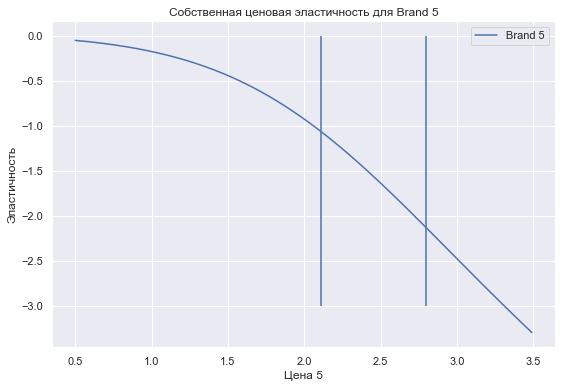

In [84]:
plt.figure(figsize=(9,6))
plt.plot(price_range, own_price_elasticity_brand_5)
plt.xlabel('Цена 5')
plt.ylabel('Эластичность')
plt.title('Собственная ценовая эластичность для Brand 5')
plt.vlines(x = df_pa.Price_5.min(), ymin=-3, ymax=0.0)
plt.vlines(x = df_pa.Price_5.max(), ymin=-3, ymax=0.0)
plt.legend(['Brand 5'])
plt.show()

Вертикальными линиями обозначены реальные минимум и максимум цены на Бренд 5, взятые из набора данных
<br>В данном диапазоне цена явно эластична

### Перекрестная эластичность относительно Бренда 4

In [85]:
#Для этого берём ценовой диапазон для бренда 4 и среднюю стоимость для остальных
df_brand5_cross_brand4 = pd.DataFrame(index=np.arange(price_range.size))
df_brand5_cross_brand4["Price_1"] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4["Price_2"] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4["Price_3"] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4["Price_4"] = price_range
df_brand5_cross_brand4["Price_5"] = brand_choice['Price_5'].mean()

In [86]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [87]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [88]:
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [89]:
beta5

-1.09

In [90]:
brand5_cross_brand4 = -beta5 * price_range * pr_brand_4

In [91]:
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4

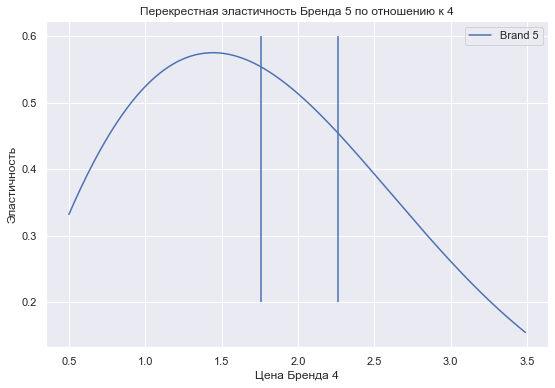

In [92]:
plt.figure(figsize=(9,6))
plt.plot(price_range, brand5_cross_brand4)
plt.xlabel('Цена Бренда 4')
plt.ylabel('Эластичность')
plt.title('Перекрестная эластичность Бренда 5 по отношению к 4')
plt.vlines(x = df_pa.Price_4.min(), ymin=0.2, ymax=0.6)
plt.vlines(x = df_pa.Price_4.max(), ymin=0.2, ymax=0.6)
plt.legend(['Brand 5'])

Снова вертикальными линиями обозначены минимальное и максимальное реальные значения цены Бренда 4
Эластичность положительна на всём диапазоне, но значение уменьшается, то есть с увеличением стоимости Бренда 4 вероятность покупки Бренда 5 будет повышаться, но всё меньше и меньше.

### Собственная и перекрёстная эластичность по сегментам


#### Well-off

In [93]:
# Нас интересует эластичность спроса на Бренд 5 по сегментам.
# Отфильтруем данные чтобы показывать только информацию по Сегменту 0.
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment_0'] == 1]

pd.options.display.max_rows = 20
brand_choice_s0

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,1,52,2,159052,2,1,1,0,0,0
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,1,52,2,159052,2,1,1,0,0,0
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,1,52,2,159052,2,1,1,0,0,0
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,1,52,2,159052,2,1,1,0,0,0
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,1,52,2,159052,2,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,...,1,44,2,193816,2,1,1,0,0,0
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,...,1,44,2,193816,2,1,1,0,0,0
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,...,1,44,2,193816,2,1,1,0,0,0
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,...,1,44,2,193816,2,1,1,0,0,0


In [94]:
# Строим модель.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s0.fit(X, Y)

# Таблица коэффициентов
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


##### $\color{orange}{\text{Собственная ценовая эластичность}}$

In [95]:
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities['Brand 5 S0'] = own_price_elasticity_brand_5_s0

##### $\color{orange}{\text{Перекрестная ценовая эластичность с брендом 4}}$

In [96]:
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities['Brand_5_Cross_Brand_4_S0'] = brand5_cross_brand4_price_elasticity_s0
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653,-0.049055,0.332011,-0.297307,0.482421
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775,-0.050616,0.337287,-0.303353,0.491726
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999,-0.052206,0.342507,-0.309409,0.501015
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327,-0.053826,0.347668,-0.315476,0.510289
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758,-0.055477,0.352773,-0.321554,0.519548
5,0.55,-0.117887,-0.193466,-0.138813,-0.042981,-0.255238,-0.147120,-0.227295,-0.057158,0.357820,-0.327644,0.528790
6,0.56,-0.122617,-0.198750,-0.143326,-0.045324,-0.262602,-0.151641,-0.233937,-0.058870,0.362809,-0.333745,0.538016
7,0.57,-0.127489,-0.204107,-0.147934,-0.047779,-0.270079,-0.156246,-0.240686,-0.060614,0.367741,-0.339859,0.547226
8,0.58,-0.132508,-0.209537,-0.152638,-0.050349,-0.277669,-0.160936,-0.247542,-0.062390,0.372614,-0.345985,0.556420
9,0.59,-0.137677,-0.215041,-0.157438,-0.053040,-0.285374,-0.165712,-0.254506,-0.064199,0.377429,-0.352124,0.565597


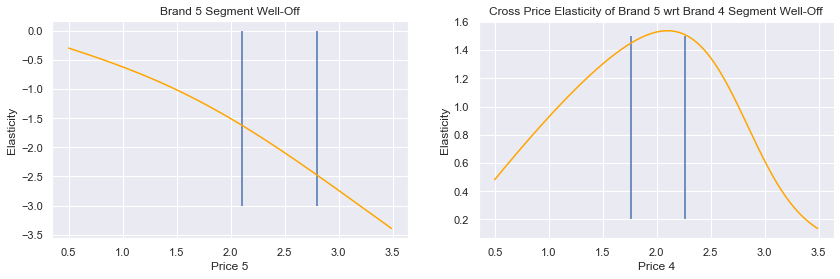

In [97]:
# Using a figure with axes we plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s0, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')
axs[0].vlines(x = df_pa.Price_5.min(), ymin=-3, ymax=0)
axs[0].vlines(x = df_pa.Price_5.max(), ymin=-3, ymax=0)

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')
axs[1].vlines(x = df_pa.Price_4.min(), ymin=0.2, ymax=1.5)
axs[1].vlines(x = df_pa.Price_4.max(), ymin=0.2, ymax=1.5)

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

#### Fewer Opportunities

In [98]:

brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment_2'] == 1]

pd.options.display.max_rows = 100
brand_choice_s2

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,0,47,1,110866,1,0,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,0,47,1,110866,1,0,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,0,47,1,110866,1,0,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,0,47,1,110866,1,0,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,0,47,1,110866,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,0,42,1,120946,1,0,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,0,42,1,120946,1,0,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,0,42,1,120946,1,0,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,0,42,1,120946,1,0,0,0,1,0


In [99]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table for segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-4.09,1.64,1.22,0.30,0.93
Price_2,0.64,-2.12,0.11,0.24,1.12
Price_3,1.28,0.19,1.26,-0.35,-2.38
Price_4,1.24,-0.36,1.64,-1.47,-1.05
Price_5,0.85,1.34,0.23,0.59,-3.01


##### $\color{orange}{\text{Собственная ценовая эластичность}}$

In [100]:
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities['Brand 5 S2'] = own_price_elasticity_brand_5_s2

##### $\color{orange}{\text{Перекрестная эластичность}}$

In [101]:
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities['Brand_5_Cross_Brand_4_S2'] = brand5_cross_brand4_price_elasticity_s2
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S2,Brand_5_Cross_Brand_4_S2
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653,-0.049055,0.332011,-0.297307,0.482421,-0.000818,0.156809
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775,-0.050616,0.337287,-0.303353,0.491726,-0.000868,0.158898
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999,-0.052206,0.342507,-0.309409,0.501015,-0.000920,0.160948
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327,-0.053826,0.347668,-0.315476,0.510289,-0.000975,0.162960
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758,-0.055477,0.352773,-0.321554,0.519548,-0.001033,0.164934
5,0.55,-0.117887,-0.193466,-0.138813,-0.042981,-0.255238,-0.147120,-0.227295,-0.057158,0.357820,-0.327644,0.528790,-0.001094,0.166871
6,0.56,-0.122617,-0.198750,-0.143326,-0.045324,-0.262602,-0.151641,-0.233937,-0.058870,0.362809,-0.333745,0.538016,-0.001159,0.168770
7,0.57,-0.127489,-0.204107,-0.147934,-0.047779,-0.270079,-0.156246,-0.240686,-0.060614,0.367741,-0.339859,0.547226,-0.001227,0.170631
8,0.58,-0.132508,-0.209537,-0.152638,-0.050349,-0.277669,-0.160936,-0.247542,-0.062390,0.372614,-0.345985,0.556420,-0.001298,0.172456
9,0.59,-0.137677,-0.215041,-0.157438,-0.053040,-0.285374,-0.165712,-0.254506,-0.064199,0.377429,-0.352124,0.565597,-0.001373,0.174244


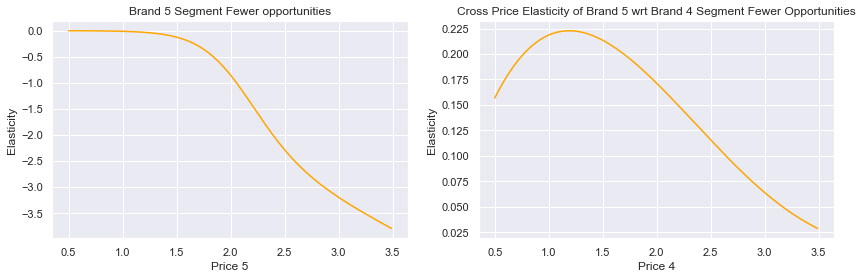

In [102]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s2, color = 'orange')
axs[0].set_title('Brand 5 Segment Fewer opportunities')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Fewer Opportunities')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

#### Career-Focused

In [103]:

brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment_1'] == 1]

pd.options.display.max_rows = 20
brand_choice_s1

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
376,200000005,51,1,5,1,0,0,1.35,1.87,1.93,...,0,49,1,121466,1,2,0,1,0,0
377,200000005,57,1,5,1,5,1,1.39,1.90,1.91,...,0,49,1,121466,1,2,0,1,0,0
394,200000005,159,1,5,2,0,0,1.39,1.90,1.94,...,0,49,1,121466,1,2,0,1,0,0
396,200000005,178,1,5,3,0,0,1.48,1.50,1.99,...,0,49,1,121466,1,2,0,1,0,0
410,200000005,249,1,5,1,0,0,1.46,1.89,1.99,...,0,49,1,121466,1,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57586,200000491,690,1,5,2,5,1,1.50,1.87,2.06,...,0,35,1,150237,2,2,0,1,0,0
57587,200000491,697,1,5,5,5,1,1.42,1.51,1.97,...,0,35,1,150237,2,2,0,1,0,0
57588,200000491,704,1,5,5,5,1,1.41,1.85,2.01,...,0,35,1,150237,2,2,0,1,0,0
57589,200000491,714,1,5,1,5,1,1.50,1.80,2.09,...,0,35,1,150237,2,2,0,1,0,0


In [104]:

Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)


bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-1.91,0.90,1.25,-0.08,-0.17
Price_2,0.63,-1.67,0.07,0.46,0.51
Price_3,1.12,0.08,0.41,-1.66,0.05
Price_4,-0.17,1.02,0.31,-1.14,-0.01
Price_5,-0.11,-0.36,0.33,0.58,-0.43


##### $\color{orange}{\text{Собственная ценовая эластичность}}$

In [105]:
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities['Brand 5 S1'] = own_price_elasticity_brand_5_s1

##### $\color{orange}{\text{Перекрестная эластичность}}$

In [106]:
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities['Brand_5_Cross_Brand_4_S1'] = brand5_cross_brand4_price_elasticity_s1
pd.options.display.max_rows = 20
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S1,Brand_5_Cross_Brand_4_S1
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653,-0.049055,0.332011,-0.297307,0.482421,-0.000818,0.156809,-0.050919,0.196705
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775,-0.050616,0.337287,-0.303353,0.491726,-0.000868,0.158898,-0.052061,0.199182
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999,-0.052206,0.342507,-0.309409,0.501015,-0.000920,0.160948,-0.053209,0.201607
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327,-0.053826,0.347668,-0.315476,0.510289,-0.000975,0.162960,-0.054363,0.203980
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758,-0.055477,0.352773,-0.321554,0.519548,-0.001033,0.164934,-0.055522,0.206300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686,-12.353623,-5.062334,-4.861790,-4.983390,-3.231570,0.162237,-3.337313,0.157466,-3.747492,0.030858,-1.082917,0.059889
296,3.46,-8.038137,-4.038021,-5.468424,-12.390027,-5.079102,-4.879992,-5.000297,-3.247764,0.160337,-3.350643,0.152045,-3.758897,0.030299,-1.091426,0.059271
297,3.47,-8.063355,-4.052873,-5.488126,-12.426413,-5.095852,-4.898164,-5.017183,-3.263926,0.158451,-3.363970,0.146789,-3.770282,0.029748,-1.099994,0.058658
298,3.48,-8.088539,-4.067709,-5.507791,-12.462782,-5.112585,-4.916305,-5.034050,-3.280055,0.156579,-3.377294,0.141694,-3.781649,0.029204,-1.108620,0.058050


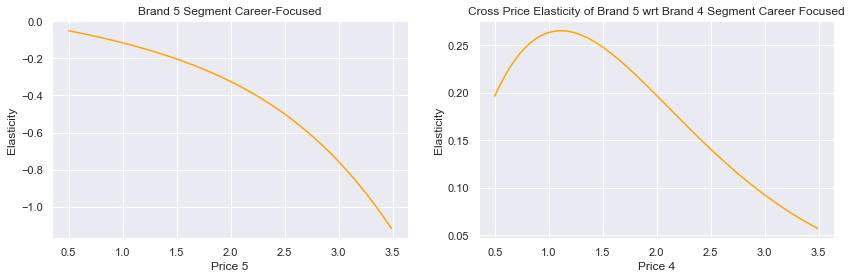

In [107]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s1, color = 'orange')
axs[0].set_title('Brand 5 Segment Career-Focused')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Career Focused')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

#### Standard

In [108]:
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment_3'] == 1]

pd.options.display.max_rows = 20
brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,1,32,1,88428,0,0,0,0,0,1
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,...,1,32,1,88428,0,0,0,0,0,1
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,...,1,32,1,88428,0,0,0,0,0,1
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,...,1,32,1,88428,0,0,0,0,0,1
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,...,1,32,1,88428,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58436,200000498,579,1,3,5,3,1,1.22,1.89,2.01,...,1,29,1,114784,1,0,0,0,0,1
58444,200000498,626,1,3,3,0,0,1.48,1.57,2.06,...,1,29,1,114784,1,0,0,0,0,1
58450,200000498,657,1,2,5,0,0,1.26,1.88,2.06,...,1,29,1,114784,1,0,0,0,0,1
58453,200000498,675,1,2,5,0,0,1.42,1.85,2.06,...,1,29,1,114784,1,0,0,0,0,1


In [109]:
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.95,1.25,1.25,0.20,0.25
Price_2,0.66,-2.25,0.30,0.26,1.03
Price_3,1.21,-0.63,0.41,-0.03,-0.95
Price_4,0.66,-0.21,1.13,-1.39,-0.20
Price_5,0.26,1.40,0.88,-1.10,-1.44


##### $\color{orange}{\text{Собственная ценовая эластичность}}$

In [110]:
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

##### $\color{orange}{\text{Перекрестная эластичность}}$

In [111]:
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = 20
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653,-0.049055,0.332011,-0.297307,0.482421,-0.000818,0.156809,-0.050919,0.196705,-0.106052,0.201059
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775,-0.050616,0.337287,-0.303353,0.491726,-0.000868,0.158898,-0.052061,0.199182,-0.108854,0.203361
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999,-0.052206,0.342507,-0.309409,0.501015,-0.000920,0.160948,-0.053209,0.201607,-0.111692,0.205599
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327,-0.053826,0.347668,-0.315476,0.510289,-0.000975,0.162960,-0.054363,0.203980,-0.114565,0.207775
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758,-0.055477,0.352773,-0.321554,0.519548,-0.001033,0.164934,-0.055522,0.206300,-0.117475,0.209889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686,-12.353623,-5.062334,-4.861790,-4.983390,-3.231570,0.162237,-3.337313,0.157466,-3.747492,0.030858,-1.082917,0.059889,-3.684113,0.014870
296,3.46,-8.038137,-4.038021,-5.468424,-12.390027,-5.079102,-4.879992,-5.000297,-3.247764,0.160337,-3.350643,0.152045,-3.758897,0.030299,-1.091426,0.059271,-3.696663,0.014599
297,3.47,-8.063355,-4.052873,-5.488126,-12.426413,-5.095852,-4.898164,-5.017183,-3.263926,0.158451,-3.363970,0.146789,-3.770282,0.029748,-1.099994,0.058658,-3.709180,0.014332
298,3.48,-8.088539,-4.067709,-5.507791,-12.462782,-5.112585,-4.916305,-5.034050,-3.280055,0.156579,-3.377294,0.141694,-3.781649,0.029204,-1.108620,0.058050,-3.721665,0.014070


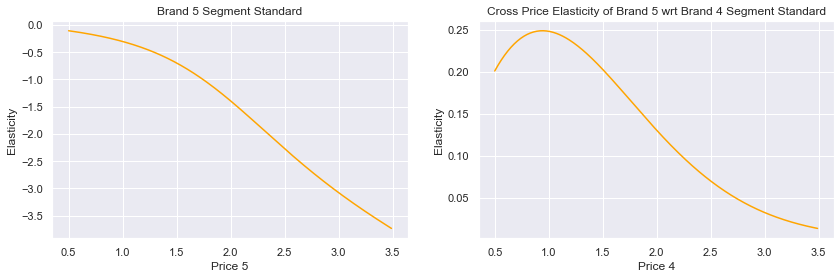

In [112]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment Standard')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Standard')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

#### Графики

Text(0.5, 0, 'Price 4')

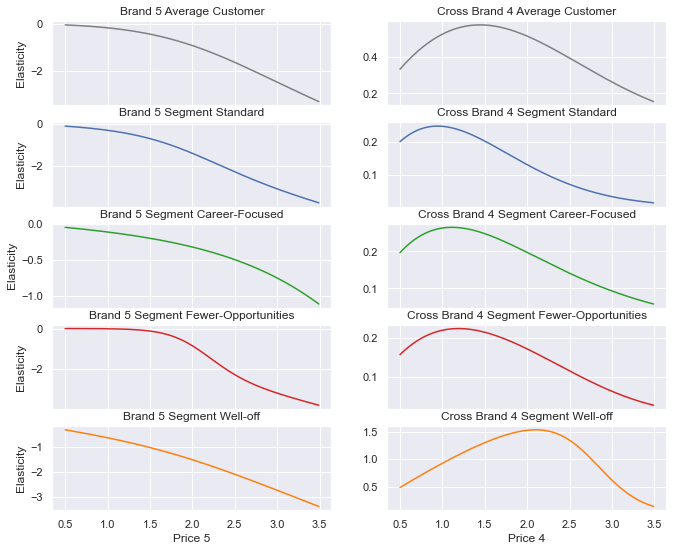

In [113]:
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s3)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s0, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')


## Эластичность числа покупок по цене

In [114]:
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]
df_purchase_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,0,47,1,110866,1,0,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,0,47,1,110866,1,0,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,0,47,1,110866,1,0,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,0,47,1,110866,1,0,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,0,47,1,110866,1,0,0,0,1,0


In [115]:
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,0.797513,0.231657,0.300178,0.315754,0.152412,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,0.810358,0.421906,0.458351,0.464831,0.359432,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [116]:
df_purchase_quantity.columns.values

array(['ID', 'Day', 'Incidence', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3', 'Brand_1',
       'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5'], dtype=object)

In [117]:
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

In [118]:
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

## Линейная регрессия


In [119]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
pd.options.display.max_rows = 100
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [120]:
Y = df_purchase_quantity['Quantity']
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [121]:
model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression()

In [122]:
model_quantity.coef_

array([-0.8173651 , -0.10504673])

## Оценка эластичности

In [123]:
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

In [124]:
beta_quantity = model_quantity.coef_[0]
beta_quantity

-0.8173651016684998

In [125]:
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [126]:
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

In [127]:
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653,-0.049055,0.332011,-0.297307,0.482421,-0.000818,0.156809,-0.050919,0.196705,-0.106052,0.201059,-0.102157
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775,-0.050616,0.337287,-0.303353,0.491726,-0.000868,0.158898,-0.052061,0.199182,-0.108854,0.203361,-0.104413
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999,-0.052206,0.342507,-0.309409,0.501015,-0.000920,0.160948,-0.053209,0.201607,-0.111692,0.205599,-0.106679
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327,-0.053826,0.347668,-0.315476,0.510289,-0.000975,0.162960,-0.054363,0.203980,-0.114565,0.207775,-0.108954
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758,-0.055477,0.352773,-0.321554,0.519548,-0.001033,0.164934,-0.055522,0.206300,-0.117475,0.209889,-0.111238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686,-12.353623,-5.062334,-4.861790,-4.983390,-3.231570,0.162237,-3.337313,0.157466,-3.747492,0.030858,-1.082917,0.059889,-3.684113,0.014870,-1.774292
296,3.46,-8.038137,-4.038021,-5.468424,-12.390027,-5.079102,-4.879992,-5.000297,-3.247764,0.160337,-3.350643,0.152045,-3.758897,0.030299,-1.091426,0.059271,-3.696663,0.014599,-1.788634
297,3.47,-8.063355,-4.052873,-5.488126,-12.426413,-5.095852,-4.898164,-5.017183,-3.263926,0.158451,-3.363970,0.146789,-3.770282,0.029748,-1.099994,0.058658,-3.709180,0.014332,-1.803124
298,3.48,-8.088539,-4.067709,-5.507791,-12.462782,-5.112585,-4.916305,-5.034050,-3.280055,0.156579,-3.377294,0.141694,-3.781649,0.029204,-1.108620,0.058050,-3.721665,0.014070,-1.817766


Text(0.5, 1.0, 'Эластичность количества покупок по цене с промоакцией')

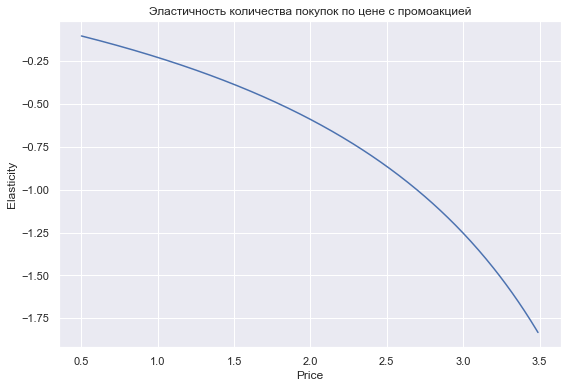

In [128]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Эластичность количества покупок по цене с промоакцией')

In [129]:
df_price_elasticity_quantity['Promotion_Incidence'] = 0

predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity

df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096272,-0.168122,-0.117613,-0.032778,-0.220092,-0.125739,-0.195653,-0.049055,0.332011,-0.297307,0.482421,-0.000818,0.156809,-0.050919,0.196705,-0.106052,0.201059,-0.102157,-0.099543
1,0.51,-0.100335,-0.173049,-0.121675,-0.034631,-0.226900,-0.129855,-0.201775,-0.050616,0.337287,-0.303353,0.491726,-0.000868,0.158898,-0.052061,0.199182,-0.108854,0.203361,-0.104413,-0.101736
2,0.52,-0.104525,-0.178047,-0.125825,-0.036574,-0.233818,-0.134051,-0.207999,-0.052206,0.342507,-0.309409,0.501015,-0.000920,0.160948,-0.053209,0.201607,-0.111692,0.205599,-0.106679,-0.103939
3,0.53,-0.108845,-0.183115,-0.130063,-0.038610,-0.240847,-0.138326,-0.214327,-0.053826,0.347668,-0.315476,0.510289,-0.000975,0.162960,-0.054363,0.203980,-0.114565,0.207775,-0.108954,-0.106150
4,0.54,-0.113298,-0.188255,-0.134392,-0.040745,-0.247986,-0.142682,-0.220758,-0.055477,0.352773,-0.321554,0.519548,-0.001033,0.164934,-0.055522,0.206300,-0.117475,0.209889,-0.111238,-0.108369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012885,-4.023153,-5.448686,-12.353623,-5.062334,-4.861790,-4.983390,-3.231570,0.162237,-3.337313,0.157466,-3.747492,0.030858,-1.082917,0.059889,-3.684113,0.014870,-1.774292,-1.664290
296,3.46,-8.038137,-4.038021,-5.468424,-12.390027,-5.079102,-4.879992,-5.000297,-3.247764,0.160337,-3.350643,0.152045,-3.758897,0.030299,-1.091426,0.059271,-3.696663,0.014599,-1.788634,-1.677205
297,3.47,-8.063355,-4.052873,-5.488126,-12.426413,-5.095852,-4.898164,-5.017183,-3.263926,0.158451,-3.363970,0.146789,-3.770282,0.029748,-1.099994,0.058658,-3.709180,0.014332,-1.803124,-1.690246
298,3.48,-8.088539,-4.067709,-5.507791,-12.462782,-5.112585,-4.916305,-5.034050,-3.280055,0.156579,-3.377294,0.141694,-3.781649,0.029204,-1.108620,0.058050,-3.721665,0.014070,-1.817766,-1.703414


Text(0.5, 1.0, 'Эластичность количества покупок по цене без промоакции')

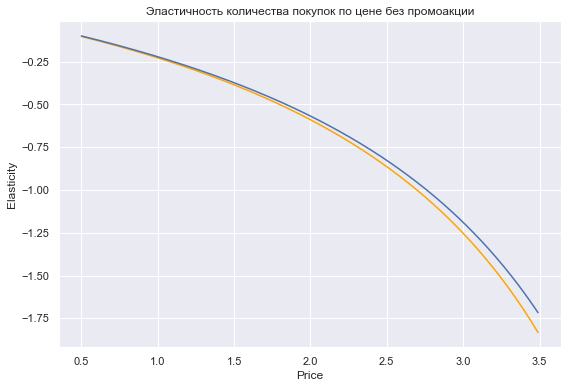

In [130]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'orange')
plt.plot(price_range, price_elasticity_quantity_promotion_no)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Эластичность количества покупок по цене без промоакции')